/opt/anaconda3/envs/tirocinio_IA/lib/python3.11/site-packages/shapely/predicates.py:526: RuntimeWarning: invalid value encountered in contains
  return lib.contains(a, b, **kwargs)
/opt/anaconda3/envs/tirocinio_IA/lib/python3.11/site-packages/shapely/set_operations.py:421: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/opt/anaconda3/envs/tirocinio_IA/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


Rotazione 0° -> Totale cerchi: 75
Rotazione 2° -> Totale cerchi: 73
Rotazione 4° -> Totale cerchi: 73
Rotazione 6° -> Totale cerchi: 73
Rotazione 8° -> Totale cerchi: 72
Rotazione 10° -> Totale cerchi: 73
Rotazione 12° -> Totale cerchi: 73
Rotazione 14° -> Totale cerchi: 73
Rotazione 16° -> Totale cerchi: 75
Rotazione 18° -> Totale cerchi: 74
Rotazione 20° -> Totale cerchi: 74
Rotazione 22° -> Totale cerchi: 75
Rotazione 24° -> Totale cerchi: 76
Rotazione 26° -> Totale cerchi: 75
Rotazione 28° -> Totale cerchi: 75
Rotazione 30° -> Totale cerchi: 73
Rotazione 32° -> Totale cerchi: 74
Rotazione 34° -> Totale cerchi: 74
Rotazione 36° -> Totale cerchi: 72
Rotazione 38° -> Totale cerchi: 76
Rotazione 40° -> Totale cerchi: 74
Rotazione 42° -> Totale cerchi: 72
Rotazione 44° -> Totale cerchi: 74
Rotazione 46° -> Totale cerchi: 76
Rotazione 48° -> Totale cerchi: 74
Rotazione 50° -> Totale cerchi: 72
Rotazione 52° -> Totale cerchi: 75
Rotazione 54° -> Totale cerchi: 74
Rotazione 56° -> Totale c

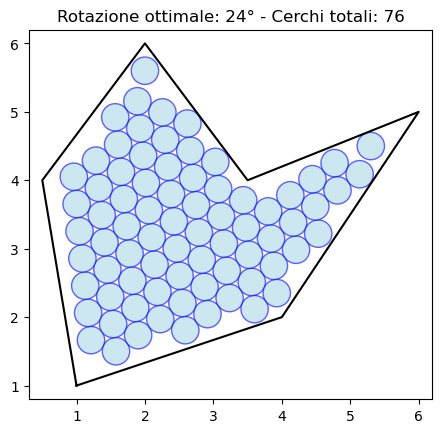

Rotazione migliore: 24°, Totale cerchi: 76
Risultato esportato in 'polygon_with_circles.json'


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely import affinity
from shapely.ops import unary_union
import json


def generate_hex_grid(polygon: Polygon, radius: float, angle: float = 0):
    # Applica rotazione al poligono
    rotated_polygon = affinity.rotate(polygon, angle, origin='centroid')
    
    minx, miny, maxx, maxy = rotated_polygon.bounds

    dx = 2 * radius
    dy = np.sqrt(3) * radius

    points = []
    y = miny
    row = 0
    while y <= maxy:
        x = minx + (radius if row % 2 else 0)
        while x <= maxx:
            center = Point(x, y)
            if rotated_polygon.contains(center.buffer(radius)):
                points.append((x, y))
            x += dx
        y += dy
        row += 1

    # Ruota indietro i punti
    rotated_back = [affinity.rotate(Point(x, y), -angle, origin=polygon.centroid) for x, y in points]
    return [(p.x, p.y) for p in rotated_back]


#metodo che controlla se un nuovo cerchio può essere aggiunto senza collisioni
def add_extra_circles(polygon: Polygon, existing_centers: list, radius: float, spacing: float = 0.5):
    minx, miny, maxx, maxy = polygon.bounds
    new_points = []

    # Crea i buffer dei cerchi esistenti per confronto geometrico
    existing_buffers = [Point(x, y).buffer(radius) for x, y in existing_centers]
    all_buffers = unary_union(existing_buffers)  # Unione dei cerchi già piazzati

    dx = spacing * radius
    dy = spacing * radius

    x_vals = np.arange(minx, maxx + dx, dx)
    y_vals = np.arange(miny, maxy + dy, dy)

    for x in x_vals:
        for y in y_vals:
            center = Point(x, y)
            buffer = center.buffer(radius)

            if not polygon.contains(buffer):
                continue

            # Controllo preciso: il nuovo cerchio non deve intersecare altri
            if all_buffers.intersects(buffer):
                continue

            # Aggiungilo e aggiorna unione
            new_points.append((x, y))
            all_buffers = unary_union([all_buffers, buffer])

    return new_points



def plot_packing(polygon: Polygon, centers: list, radius: float, title="Packing"):
    fig, ax = plt.subplots()
    x, y = polygon.exterior.xy
    ax.plot(x, y, color='black')

    for cx, cy in centers:
        circle = plt.Circle((cx, cy), radius, edgecolor='blue', facecolor='lightblue', alpha=0.6)
        ax.add_patch(circle)

    ax.set_aspect('equal')
    ax.set_xlim(polygon.bounds[0] - radius, polygon.bounds[2] + radius)
    ax.set_ylim(polygon.bounds[1] - radius, polygon.bounds[3] + radius)
    plt.title(f"{title} - Cerchi totali: {len(centers)}")
    plt.show()


#metodo che trova la rotazione ottimale per il packing
def find_best_rotation(polygon: Polygon, radius: float, angles=None):
    if angles is None:
        angles = np.arange(0, 62, 2)  # Rotazioni da 0° a 55° ogni 5°

    best_centers = []
    best_angle = 0

    for angle in angles:
        base_centers = generate_hex_grid(polygon, radius, angle=angle)
        extra_centers = add_extra_circles(polygon, base_centers, radius)
        total = base_centers + extra_centers

        print(f"Rotazione {angle}° -> Totale cerchi: {len(total)}")
        if len(total) > len(best_centers):
            best_centers = total
            best_angle = angle

    return best_centers, best_angle


if __name__ == "__main__":
    # Carica i punti
    with open("polygon.json", "r") as f:
        vertices = json.load(f)

    # Separali in X e Y
    x, y = zip(*vertices)
    poly = Polygon(vertices)

    circle_radius = 0.2

    # Trova la miglior disposizione
    best_centers, best_angle = find_best_rotation(poly, circle_radius)

    # Visualizza
    plot_packing(poly, best_centers, circle_radius, title=f"Rotazione ottimale: {best_angle}°")
    print(f"Rotazione migliore: {best_angle}°, Totale cerchi: {len(best_centers)}")

    # Prepara il JSON da esportare
    export_data = {
        "polygon": vertices,
        "circles": [
            {"center": [x, y], "radius": circle_radius}
            for x, y in best_centers
        ]
    }

    # Esporta in JSON
    with open("polygon_with_circles.json", "w") as f:
        json.dump(export_data, f, indent=2)

    print("Risultato esportato in 'polygon_with_circles.json'")

In [17]:
def calcola_configurazione_batteria(v_cella, ah_cella, v_target, ah_target, celle_disponibili):
    s = round(v_target / v_cella)
    p = round(ah_target / ah_cella)
    totale = s * p

    print(f"Configurazione suggerita: {s}S{p}P")
    print(f"Celle totali richieste: {totale}")

    if totale <= celle_disponibili:
        print("Le celle entrano nella forma disponibile.")
    else:
        print("Troppe celle. Considera di abbassare la capacità o cambiare disposizione.")
    return s, p, totale

# Esempio
calcola_configurazione_batteria(
    v_cella=3.6,
    ah_cella=2.5,
    v_target=37,
    ah_target=18,
    celle_disponibili=76
)

Configurazione suggerita: 10S7P
Celle totali richieste: 70
Le celle entrano nella forma disponibile.


(10, 7, 70)

✅ Polarità assegnate e salvate in 'labeled_cells.json'


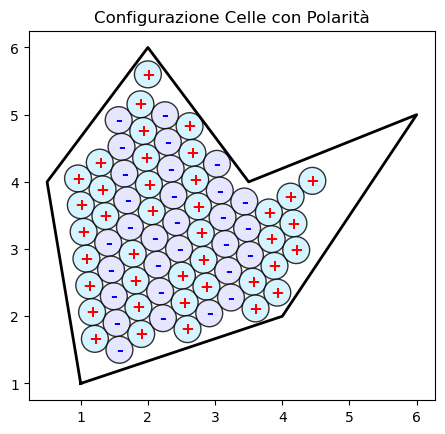

In [19]:
import json
import matplotlib.pyplot as plt
from shapely.geometry import Polygon


def assign_polarities(input_json, output_json, S, P):
    # Step 1: Carica il JSON
    with open(input_json, 'r') as f:
        data = json.load(f)

    circles = data['circles']

    if len(circles) < S * P:
        raise ValueError(f"Non ci sono abbastanza celle ({len(circles)}) per la configurazione richiesta {S}S{P}P.")

    # Step 2: Estrai e ordina i centri
    centers = [(c['center'][0], c['center'][1]) for c in circles]
    radius = circles[0]['radius']  # Assumiamo stesso raggio per tutte

    # Ordina: da sinistra a destra, poi dal basso verso l'alto
    ordered = sorted(centers, key=lambda p: (p[0], p[1]))

    # Step 3: Raggruppa in S gruppi da P
    usable = ordered[:S * P]
    groups = [usable[i * P:(i + 1) * P] for i in range(S)]

    # Step 4: Assegna polarità alternata per serie
    labeled_cells = []
    for i, group in enumerate(groups):
        polarity = '+' if i % 2 == 0 else '-'
        for cx, cy in group:
            labeled_cells.append({
                "center": [cx, cy],
                "radius": radius,
                "polarity": polarity
            })

    # Step 5: Esporta nuovo JSON
    output = {
        "polygon": data.get("polygon", []),
        "circles": labeled_cells
    }

    with open(output_json, 'w') as f:
        json.dump(output, f, indent=2)

    print(f"✅ Polarità assegnate e salvate in '{output_json}'")

    # Step 6: Disegna risultato
    plot_labeled_cells(output)


def plot_labeled_cells(data):
    fig, ax = plt.subplots()
    
    # Disegna il poligono
    if "polygon" in data and data["polygon"]:
        poly = Polygon(data["polygon"])
        x, y = poly.exterior.xy
        ax.plot(x, y, color='black', linewidth=2)

    # Disegna le celle
    for cell in data["circles"]:
        cx, cy = cell["center"]
        r = cell["radius"]
        polarity = cell["polarity"]

        color = 'red' if polarity == '+' else 'blue'
        face_color = '#ccf2ff' if polarity == '+' else '#e0e0ff'

        # Cerchio
        circle = plt.Circle((cx, cy), r, edgecolor='black', facecolor=face_color, alpha=0.8)
        ax.add_patch(circle)

        # Simbolo + o -
        ax.text(cx, cy, polarity, color=color, fontsize=12, weight='bold', ha='center', va='center')

    ax.set_aspect('equal')
    ax.set_title("Configurazione Celle con Polarità")
    plt.show()


# Esempio di utilizzo
if __name__ == "__main__":
    assign_polarities(
        input_json="polygon_with_circles.json",
        output_json="labeled_cells.json",
        S=7,
        P=10
    )

✅ Polarità assegnate e salvate in 'labeled_cells.json'


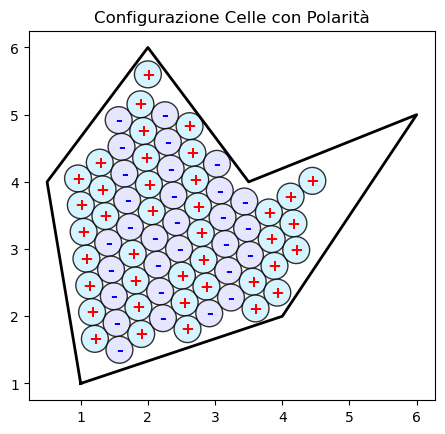

In [21]:
import json
import matplotlib.pyplot as plt
from shapely.geometry import Polygon


def assign_polarities(input_json, output_json, S, P):
    # Step 1: Carica il JSON
    with open(input_json, 'r') as f:
        data = json.load(f)

    circles = data['circles']

    if len(circles) < S * P:
        raise ValueError(f"Non ci sono abbastanza celle ({len(circles)}) per la configurazione richiesta {S}S{P}P.")

    # Step 2: Estrai e ordina i centri
    centers = [(c['center'][0], c['center'][1]) for c in circles]
    radius = circles[0]['radius']  # Assumiamo stesso raggio per tutte

    # Ordina: da sinistra a destra, poi dal basso verso l'alto
    ordered = sorted(centers, key=lambda p: (p[0], p[1]))

    # Step 3: Raggruppa in S gruppi da P
    usable = ordered[:S * P]
    groups = [usable[i * P:(i + 1) * P] for i in range(S)]

    # Step 4: Assegna polarità alternata per serie
    labeled_cells = []
    for i, group in enumerate(groups):
        polarity = '+' if i % 2 == 0 else '-'
        for cx, cy in group:
            labeled_cells.append({
                "center": [cx, cy],
                "radius": radius,
                "polarity": polarity
            })

    # Step 5: Esporta nuovo JSON
    output = {
        "polygon": data.get("polygon", []),
        "circles": labeled_cells
    }

    with open(output_json, 'w') as f:
        json.dump(output, f, indent=2)

    print(f"✅ Polarità assegnate e salvate in '{output_json}'")

    # Step 6: Disegna risultato
    plot_labeled_cells(output)

def group_cells_by_rows(centers, S, P, tolerance=0.05):
    """
    Raggruppa le celle per righe simili in Y (entro una tolleranza),
    poi le ordina per X per ottenere blocchi paralleli consistenti.
    """
    # Ordina per Y (dall’alto verso il basso)
    centers = sorted(centers, key=lambda p: p[1])

    rows = []
    current_row = []
    last_y = None

    for cx, cy in centers:
        if last_y is None or abs(cy - last_y) < tolerance:
            current_row.append((cx, cy))
        else:
            rows.append(current_row)
            current_row = [(cx, cy)]
        last_y = cy
    if current_row:
        rows.append(current_row)

    # Ordina ogni riga da sinistra a destra
    for row in rows:
        row.sort(key=lambda p: p[0])

    # Flatten righe in ordine e formiamo i gruppi
    flat_cells = [cell for row in rows for cell in row]

    total_required = S * P
    if len(flat_cells) < total_required:
        raise ValueError(f"Non ci sono abbastanza celle ({len(flat_cells)}) per {S}S{P}P")

    usable = flat_cells[:total_required]

    # Crea gruppi da P (ogni gruppo è una serie)
    #groups = [usable[i * P:(i + 1) * P] for i in range(S)]
    groups = group_cells_by_rows(centers, S, P)
    return groups


def plot_labeled_cells(data):
    fig, ax = plt.subplots()
    
    # Disegna il poligono
    if "polygon" in data and data["polygon"]:
        poly = Polygon(data["polygon"])
        x, y = poly.exterior.xy
        ax.plot(x, y, color='black', linewidth=2)

    # Disegna le celle
    for cell in data["circles"]:
        cx, cy = cell["center"]
        r = cell["radius"]
        polarity = cell["polarity"]

        color = 'red' if polarity == '+' else 'blue'
        face_color = '#ccf2ff' if polarity == '+' else '#e0e0ff'

        # Cerchio
        circle = plt.Circle((cx, cy), r, edgecolor='black', facecolor=face_color, alpha=0.8)
        ax.add_patch(circle)

        # Simbolo + o -
        ax.text(cx, cy, polarity, color=color, fontsize=12, weight='bold', ha='center', va='center')

    ax.set_aspect('equal')
    ax.set_title("Configurazione Celle con Polarità")
    plt.show()


# Esempio di utilizzo
if __name__ == "__main__":
    assign_polarities(
        input_json="polygon_with_circles.json",
        output_json="labeled_cells.json",
        S=7,
        P=10
    )

In [5]:
import json
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np
from sklearn.cluster import DBSCAN


def calcola_configurazione_batteria(v_cella, ah_cella, v_target, ah_target, celle_disponibili):
    s = round(v_target / v_cella)
    p = round(ah_target / ah_cella)
    totale = s * p

    print(f"Configurazione suggerita: {s}S{p}P")
    print(f"Celle totali richieste: {totale}")

    if totale <= celle_disponibili:
        print("Le celle entrano nella forma disponibile.")
    else:
        print("⚠️ Troppe celle. Considera di abbassare la capacità o cambiare disposizione.")
    return s, p, totale

def assign_from_grid(centers, radius, S, P, tolerance=0.3):
    centers = np.array(centers)

    # Clusterizza per Y (altezza) per ottenere le righe
    clustering = DBSCAN(eps=radius * 1.5, min_samples=P, metric=lambda a, b: abs(a[1] - b[1]))
    labels = clustering.fit_predict(centers)

    rows_dict = {}
    for i, label in enumerate(labels):
        if label == -1:
            continue
        rows_dict.setdefault(label, []).append(centers[i])

    rows = list(rows_dict.values())

    # Ordina le celle in ogni riga da sinistra a destra
    for row in rows:
        row.sort(key=lambda p: p[0])

    rows.sort(key=lambda row: np.mean([p[1] for p in row]))  # ordina le righe dall'alto in basso

    labeled = []
    series_idx = 0

    for row in rows:
        i = 0
        while i + P <= len(row) and series_idx < S:
            group = row[i:i + P]
            polarity = '+' if series_idx % 2 == 0 else '-'
            for cx, cy in group:
                labeled.append({
                    "center": [cx, cy],
                    "radius": radius,
                    "polarity": polarity
                })
            series_idx += 1
            i += P

        if series_idx >= S:
            break

    if series_idx < S:
        raise ValueError(f"Non sono riuscito a formare {S} gruppi in serie. Trovati solo {series_idx} gruppi.")
    
    return labeled
    # Ordina per Y per trovare le righe
    centers = sorted(centers, key=lambda p: p[1])
    rows = []
    current_row = []
    last_y = None

    for cx, cy in centers:
        if last_y is None or abs(cy - last_y) < tolerance:
            current_row.append((cx, cy))
        else:
            rows.append(current_row)
            current_row = [(cx, cy)]
        last_y = cy
    if current_row:
        rows.append(current_row)

    # Ordina per X ogni riga
    for row in rows:
        row.sort(key=lambda p: p[0])

    # Appiattisci la griglia
    grid = [cell for row in rows for cell in row]

    if len(grid) < S * P:
        raise ValueError(f"Non ci sono abbastanza celle ({len(grid)}) per {S}S{P}P")

    labeled = []
    used = 0
    series_idx = 0
    for row in rows:
        if len(row) < P:
            continue
        if series_idx >= S:
            break

        group = row[:P]
        polarity = '+' if series_idx % 2 == 0 else '-'

        for cx, cy in group:
            labeled.append({
                "center": [cx, cy],
                "radius": radius,
                "polarity": polarity
            })
            used += 1
        series_idx += 1

    if used < S * P:
        raise ValueError(f"Non sono riuscito a comporre tutti i gruppi! Solo {used} celle assegnate.")
    
    return labeled

def plot_labeled_battery(polygon, cells):
    fig, ax = plt.subplots()
    # Disegna il contorno
    x, y = zip(*polygon)
    ax.plot(x, y, color='black')

    # Disegna le celle
    for cell in cells:
        cx, cy = cell["center"]
        r = cell["radius"]
        polarity = cell["polarity"]
        circle = plt.Circle((cx, cy), r, edgecolor='blue', facecolor='lightblue', alpha=0.6)
        ax.add_patch(circle)
        ax.text(cx, cy, polarity, ha='center', va='center', fontsize=10, weight='bold', color='black')

    ax.set_aspect('equal')
    plt.title("Disposizione batterie con polarità")
    plt.show()

# MAIN PROGRAM
if __name__ == "__main__":
    # STEP 1: Calcola configurazione
    S, P, total = calcola_configurazione_batteria(
        v_cella=3.6,
        ah_cella=2.5,
        v_target=37,
        ah_target=18,
        celle_disponibili=76
    )

    # STEP 2: Carica i dati dal JSON
    with open("polygon_with_circles.json", "r") as f:
        data = json.load(f)
    
    polygon = data["polygon"]
    circles = data["circles"]
    radius = circles[0]["radius"]
    centers = [tuple(c["center"]) for c in circles]

    # STEP 3: Assegna polarità
    labeled_cells = assign_from_grid(centers, radius, S, P)

    # STEP 4: Visualizza
    plot_labeled_battery(polygon, labeled_cells)

ModuleNotFoundError: No module named 'sklearn'